In [1]:
import numpy as np
from matplotlib import image
import matplotlib.pyplot as plt
import scipy.misc
import scipy
from scipy import ndimage

import argparse
import sys
import os,datetime

from IPython.display import SVG

from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf

from tensorflow.keras.preprocessing import image
from tensorflow.python.framework import ops

%matplotlib inline

Using TensorFlow backend.


In [2]:
TRAIN_DIR=os.path.join(os.getcwd(),"asl_alphabet_train")
TEST_DIR=os.path.join(os.getcwd(),"asl_alphabet_test")
imageSize=200

print(TRAIN_DIR)
def datagen(batch=32):
    
    datagen1 = ImageDataGenerator(brightness_range=[0.8,1.5],horizontal_flip=True,zoom_range=0.2, fill_mode="nearest", rescale=1./255)
    datagen2 = ImageDataGenerator(brightness_range=[0.5,1.7],horizontal_flip=True,zoom_range=0.2, fill_mode="nearest", rescale=1./255)
    
    train_generator = datagen1.flow_from_directory(TRAIN_DIR,shuffle=True, target_size = (200, 200), batch_size = batch, class_mode = 'categorical'  ) 
    val_generator = datagen2.flow_from_directory(TEST_DIR, target_size = (200, 200), batch_size = batch, class_mode = 'categorical' )

    return {"train":train_generator,"test":val_generator }

D:\PROJECTS\Github\Converse-now\asl_alphabet_train


In [3]:
GeneratedData =  datagen(32)
train = GeneratedData["train"]
test = GeneratedData["test"]
X_train_orig, Y_train_orig=train.next()
X_test_orig, Y_test_orig=test.next()

Found 156149 images belonging to 29 classes.
Found 301 images belonging to 29 classes.


23


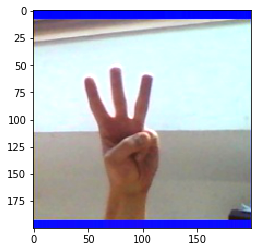

In [4]:
# Plotting Image for verification purposes
plt.imshow(X_train_orig[1])
print(np.argmax(Y_train_orig[1])+1)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.layers import Activation,Flatten,GlobalAveragePooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2 
import datetime
from tensorflow.losses import softmax_cross_entropy



In [7]:
#Added tensorboard,ReduceLRonPlateau
#Added BatchNormaliztion,
#Dont touch alpha of LeakyReLU, 0.05 is doing well
#changed adadelta to adam...tried softmax loss,not recommended...

inputDims=(imageSize,imageSize,3)

def create_model():
    model = Sequential()
    
    model.add(Conv2D(128,(3,3),input_shape=(200,200,3)))
    model.add(LeakyReLU(alpha=0.05))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.1))
    #model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
    
    model.add(Conv2D(64,(3,3),input_shape=(200,200,3)))
    model.add(LeakyReLU(alpha=0.05))
    #model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.1))
    
    #changing 128 to 64...
    model.add(Conv2D(128,kernel_size=(3,3),strides=(2,2),input_shape=(200,200,3)))
    model.add(LeakyReLU(alpha=0.05))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
    
    
    model.add(Flatten())
    
    #model.add(Dense(128))
    #model.add(Activation("relu"))
    #model.add(Dropout(0.3))
    
    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.05))
    model.add(Dropout(0.2))
    
    model.add(Dense(29))
    model.add(Activation("softmax"))
    
    return model


def train_model(model):
    
    model.compile(loss=categorical_crossentropy, metrics=['accuracy'], optimizer='adam')
    
    lrReducer = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
    
    chkpt_dir = os.path.join(os.getcwd(),"chkpts")
    checkpointer = ModelCheckpoint(filepath=os.path.join(chkpt_dir,"weights2.hdf5"), verbose=1, save_best_only=True)
    
    log_dir="logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    model.fit_generator(train,epochs=10,validation_data=test,callbacks=[tensorboard,checkpointer,lrReducer])
    
    
    
def save_trained_model(model):
    model.save("model-3Conv-2Dense-10Epoch-wCallbacks.h5")

    
def load_trained_model(weights_path):
    model = create_model()
    model.load_weights(weights_path)
    return model
    


In [7]:
modelv1 = create_model()
modelv1.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 128)     3584      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 198, 198, 128)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 99, 99, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        73792     
_________________________________________________________________
leaky_re_lu_1 (LeakyR

In [8]:
train_model(modelv1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
10/10 [==============================] - 74s 7s/step - loss: 0.8331 - acc: 0.7475

Epoch 00001: val_loss improved from inf to 0.83311, saving model to D:\PROJECTS\Github\Converse-now\chkpts\weights2.hdf5
4880/4880 [==============================] - 1947s 399ms/step - loss: 2.2456 - acc: 0.3255 - val_loss: 0.8331 - val_acc: 0.7475
Epoch 2/10
10/10 [==============================] - 75s 7s/step - loss: 0.4923 - acc: 0.8239

Epoch 00002: val_loss improved from 0.83311 to 0.49227, saving model to D:\PROJECTS\Github\Converse-now\chkpts\weights2.hdf5
4880/4880 [==============================] - 1927s 395ms/step - loss: 1.4085 - acc: 0.5479 - val_loss: 0.4923 - val_acc: 0.8239
Epoch 3/10
10/10 [==============================] - 75s 7s/step - loss: 0.4618 - acc: 0.8671

Epoch 00003: val_loss improved from 0.49227 to 0.46181, saving model to D:\PROJECTS\Github\Converse-now\chkpts\weights2.hdf5
4880/4880 [==============================] 

In [9]:
save_trained_model(modelv1)

In [9]:
import tensorflow.lite

In [12]:
converter = tensorflow.lite.TFLiteConverter.from_keras_model_file('model-3Conv-2Dense-10Epoch-wCallbacks.h5')
tfmodel = converter.convert()
open("model-3Conv-2Dense-10Epoch-wCallbacks.tflite" , "wb") .write(tfmodel)


INFO:tensorflow:Froze 14 variables.
INFO:tensorflow:Converted 14 variables to const ops.


4807804

In [8]:
newmodel = load_trained_model("D:\\PROJECTS\\Github\\Converse-now\\model-3Conv-2Dense-10Epoch-wCallbacks.h5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
newmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 128)     3584      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 198, 198, 128)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 99, 99, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        73792     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 97, 97, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 97, 97, 64)        0         
__________

In [26]:
test_dir = os.path.join(os.getcwd(),"newTest")

test_datagen = ImageDataGenerator(brightness_range=[0.8,1.5],horizontal_flip=True,zoom_range=0.2, fill_mode="nearest", rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_dir,target_size=(200, 200),color_mode="rgb",shuffle = False,class_mode='categorical',batch_size=1)

filenames = test_generator.filenames
nb_samples = len(filenames)

predict = newmodel.predict_generator(test_generator,steps = nb_samples)    

Found 16 images belonging to 29 classes.


In [27]:
print(predict.shape)
print(np.argmax(predict,axis=1))


(16, 29)
[ 0  8  2  5  4 24  4 24  3 17 17 21 16  6 27 15]


In [28]:
x = [a for a in range(30)]
dirs = os.listdir(test_dir)
maps = dict(zip(x,dirs))
print(maps)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'Zdel', 27: 'Znothing', 28: 'Zspace'}


In [29]:
print(predict.shape)
for index in np.argmax(predict,axis=1):
    print(maps[index])


(16, 29)
A
I
C
F
E
Y
E
Y
D
R
R
V
Q
G
Znothing
P
